In [ ]:
# Data files are available on the Google Drive

In [1]:
import velocycle as vc
from velocycle import *

In [2]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import copy
import scipy
import pickle

# scRNA-seq
import scanpy as sc

In [3]:
from threadpoolctl import threadpool_limits
threadpool_limits(limits=8)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use GPU


In [5]:
CELL_DOT_COLOR = "#6A8E7F"
GENE_DOT_COLOR = "#71697A"

In [6]:
# Find marker genes shared among all

## Load dataset

In [7]:
data_orig = sc.read_h5ad("E16.5_E1S3_cell_bin_whole_brain.h5ad")
data_orig.obs["batch"] = "E1S3"

In [8]:
data_orig.obsm["X_pca"] = data_orig.obsm["spatial"]

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


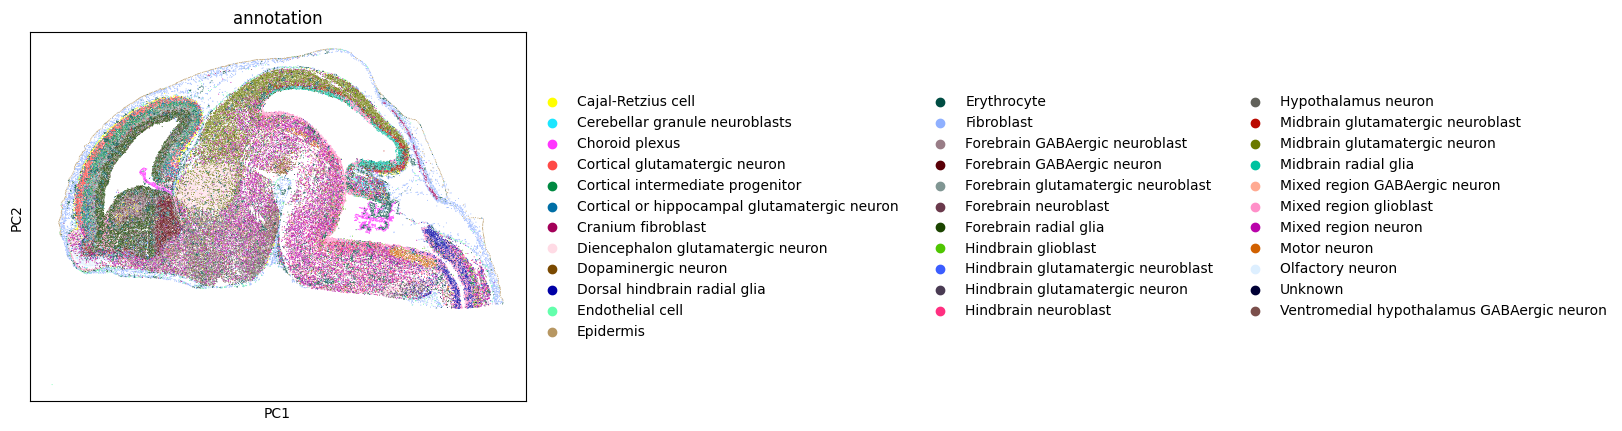

In [9]:
sc.pl.pca(data_orig, color=["annotation"])

In [10]:
data_orig

AnnData object with n_obs × n_vars = 65303 × 23368
    obs: 'Slice', 'region', 'sim anno', 'n_genes_by_counts', 'total_counts', 'annotation', 'batch'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sim anno_colors', 'annotation_colors'
    obsm: 'spatial', 'X_pca'
    layers: 'counts'

In [11]:
data_raw = sc.read_h5ad("E16.5_E1S3_adata_cell_labels_Intron_Exon_cluster.h5ad")
data_raw.obs["batch"] = "E1S3"

In [12]:
data_raw.obsm["X_umap"] = data_raw.obsm["X_spatial"]

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


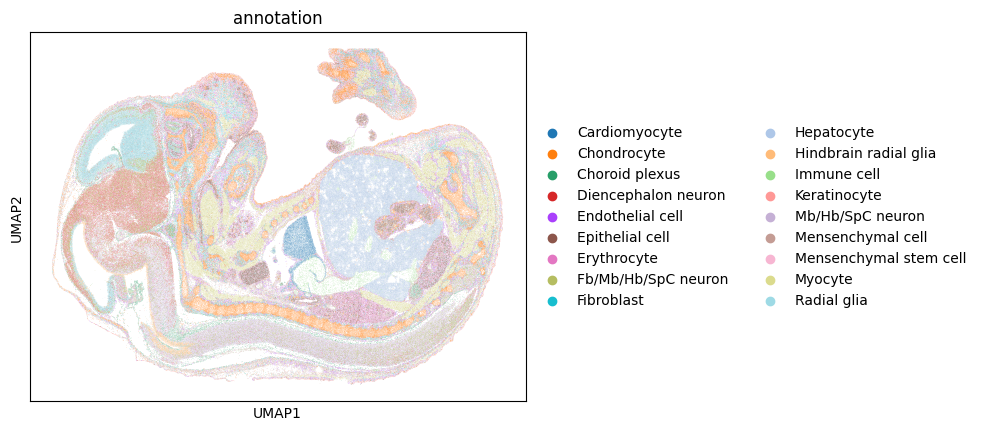

In [13]:
sc.pl.umap(data_raw, color=['annotation'])

In [14]:
data_raw.obs.index = ["CELL."+i for i in data_raw.obs.index]

In [15]:
shared_cells = np.array(sorted(list(set(data_raw.obs.index) & set(data_orig.obs.index))))

In [16]:
data_raw_brain_subset = data_raw[shared_cells, :].copy()
data_orig_subset = data_orig[shared_cells, :].copy()

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


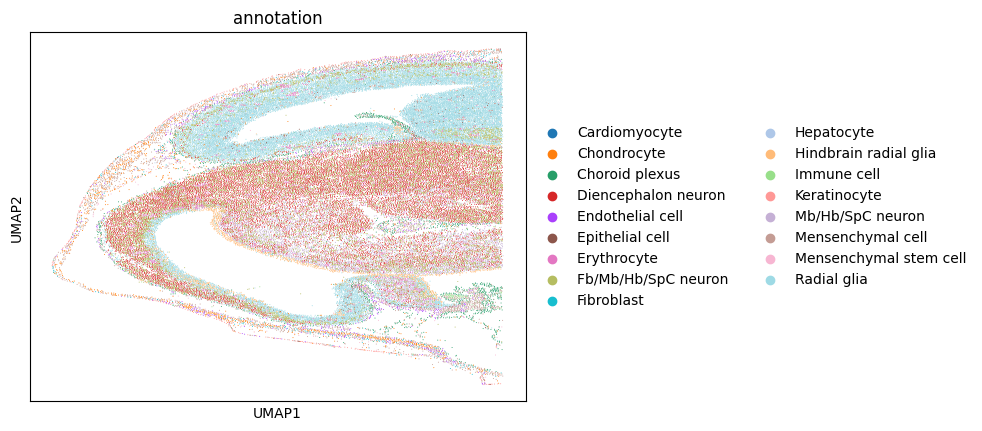

In [17]:
sc.pl.umap(data_raw_brain_subset, color=['annotation'], save="annotation.png")

In [18]:
np.alltrue(data_raw_brain_subset.obs.index == data_orig_subset.obs.index)

True

In [19]:
data_raw_brain_subset.obs["annotation2"] = data_orig_subset.obs["annotation"]

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


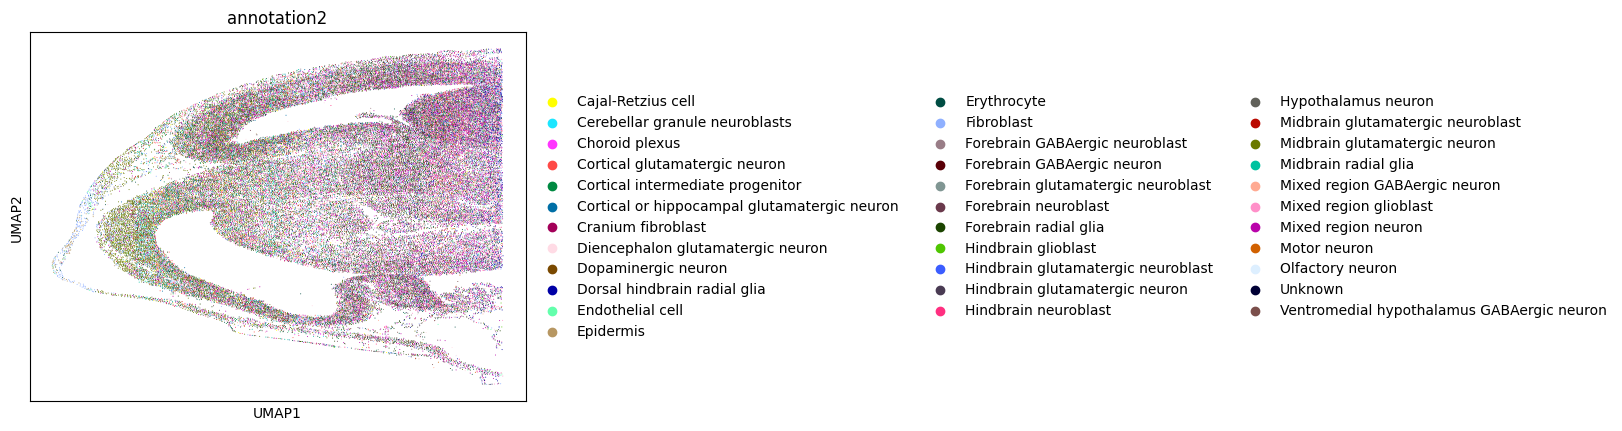

In [20]:
sc.pl.umap(data_raw_brain_subset, color=['annotation2'])

In [21]:
drbs_rg = data_raw_brain_subset[data_raw_brain_subset.obs["annotation"]=="Radial glia"].copy()

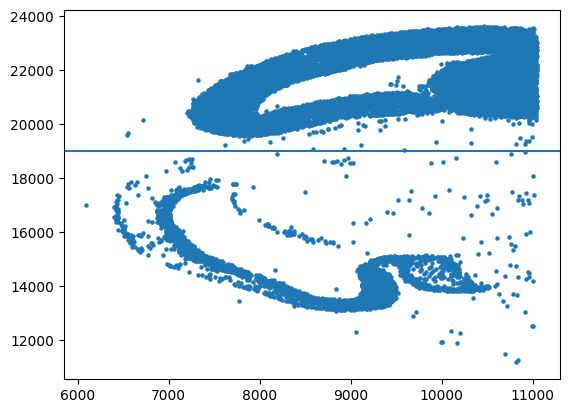

In [22]:
plt.scatter(drbs_rg.obsm["X_umap"][:, 0], drbs_rg.obsm["X_umap"][:, 1], s=5)
plt.axhline(19000)

In [23]:
drbs_rg = drbs_rg[drbs_rg.obsm["X_umap"][:, 1]>19000].copy()

In [24]:
from velocycle import utils
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(drbs_rg, s_genes=utils.S_genes_mouse, g2m_genes=utils.G2M_genes_mouse)

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


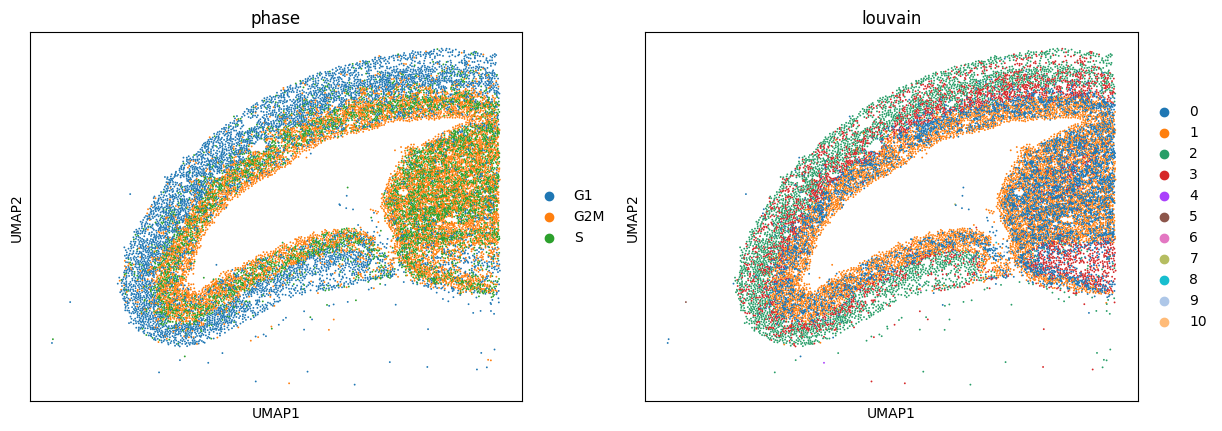

In [25]:
drbs_rg_norm = drbs_rg.copy()
sc.pp.normalize_total(drbs_rg_norm)
sc.pp.log1p(drbs_rg_norm)

sc.tl.louvain(drbs_rg_norm)
sc.pl.umap(drbs_rg_norm, color=["phase", "louvain"])

In [26]:
drbs_rg.obs["louvain"] = drbs_rg_norm.obs["louvain"]

In [27]:
drbs_rg = drbs_rg[drbs_rg.obs["louvain"].isin(["0", "1"])]
drbs_rg_norm = drbs_rg_norm[drbs_rg_norm.obs["louvain"].isin(["0", "1"])]

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


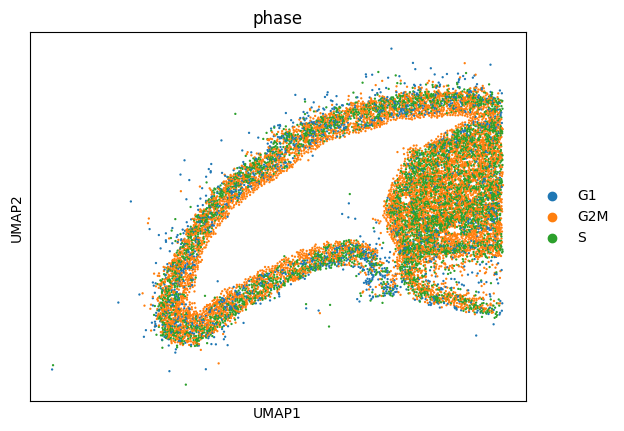

In [28]:
sc.pl.umap(drbs_rg, color='phase')

In [29]:
drbs_rg.obs["phase"].value_counts()

phase
G2M    5603
S      3780
G1     1497
Name: count, dtype: int64

In [30]:
fb=sc.read_h5ad("../../velocycle/Data/LaManno_RG_E10_Forebrain.h5ad")
mb=sc.read_h5ad("../../velocycle/Data/LaManno_RG_E10_Midbrain.h5ad")
hb=sc.read_h5ad("../../velocycle/Data/LaManno_RG_E10_Hindbrain.h5ad")

In [32]:
cycling_genes_large = utils.get_cycling_gene_set("Large", "Mouse")
shared_cycling_genes_large = sorted(np.array(list(set(cycling_genes_large) & set(drbs_rg.var.index) & set(fb.var.index))))

In [34]:
spliced_counts_by_gene_cycling = drbs_rg[:, [i in cycling_genes_large for i in drbs_rg.var.index]].layers["spliced"].toarray().mean(0)
unspliced_counts_by_gene_cycling = drbs_rg[:, [i in cycling_genes_large for i in drbs_rg.var.index]].layers["unspliced"].toarray().mean(0)
spliced_counts_by_gene_all = drbs_rg.layers["spliced"].toarray().mean(0)
unspliced_counts_by_gene_all = drbs_rg.layers["unspliced"].toarray().mean(0)

In [35]:
spliced_counts_by_gene_cycling = drbs_rg[:, shared_cycling_genes_large].layers["spliced"].toarray().mean(0)
unspliced_counts_by_gene_cycling = drbs_rg[:, shared_cycling_genes_large].layers["unspliced"].toarray().mean(0)

fb_spliced_counts_by_gene_cycling = fb[:, shared_cycling_genes_large].layers["spliced"].toarray().mean(0)
fb_unspliced_counts_by_gene_cycling = fb[:, shared_cycling_genes_large].layers["unspliced"].toarray().mean(0)

In [36]:
shared_genes_all = sorted(np.array(list(set(drbs_rg.var.index) & set(fb.var.index))))

In [37]:
rg_brain = sc.concat([fb, mb, hb])

In [38]:
spliced_counts_by_gene = drbs_rg[:, shared_genes_all].layers["spliced"].toarray().mean(0)
unspliced_counts_by_gene = drbs_rg[:, shared_genes_all].layers["unspliced"].toarray().mean(0)

fb_spliced_counts_by_gene = rg_brain[:, shared_genes_all].layers["spliced"].toarray().mean(0)
fb_unspliced_counts_by_gene = rg_brain[:, shared_genes_all].layers["unspliced"].toarray().mean(0)

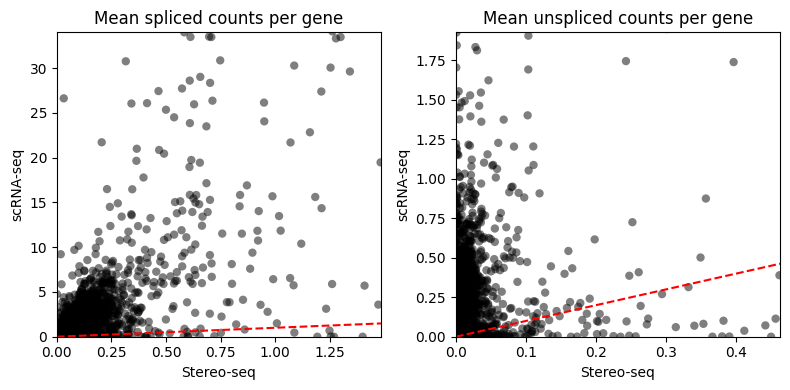

In [39]:
plt.figure(None, (8, 4))
plt.subplot(1,2,1)
plt.scatter(spliced_counts_by_gene, fb_spliced_counts_by_gene, c='black', edgecolor='none', alpha=0.5, rasterized=True)
plt.xlim(0, np.percentile(spliced_counts_by_gene, 99.9))
plt.ylim(0, np.percentile(fb_spliced_counts_by_gene, 99.9))
plt.xlabel("Stereo-seq")
plt.ylabel("scRNA-seq")
plt.title("Mean spliced counts per gene")
plt.axline((0,0), slope=1, c='red', linestyle='dashed')

plt.subplot(1,2,2)
plt.scatter(unspliced_counts_by_gene, fb_unspliced_counts_by_gene, c='black', edgecolor='none', alpha=0.5, rasterized=True)
plt.xlim(0, np.percentile(unspliced_counts_by_gene, 99.9))
plt.ylim(0, np.percentile(fb_unspliced_counts_by_gene, 99.9))
plt.xlabel("Stereo-seq")
plt.ylabel("scRNA-seq")
plt.title("Mean unspliced counts per gene")
plt.axline((0,0), slope=1, c='red', linestyle='dashed')

plt.tight_layout()
plt.show()

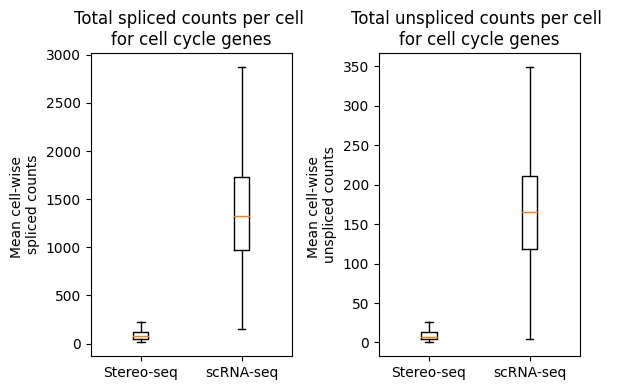

In [43]:
plt.figure(None, (6, 4))
plt.subplot(1,2,1)
plt.boxplot([drbs_rg[:, shared_cycling_genes_large].layers["spliced"].toarray().sum(1),
             rg_brain[:, shared_cycling_genes_large].layers["spliced"].toarray().sum(1)], showfliers=False)
plt.xticks([1,2], ["Stereo-seq", "scRNA-seq"])
plt.title("Total spliced counts per cell \nfor cell cycle genes")
plt.ylabel("Mean cell-wise \nspliced counts")

plt.subplot(1,2,2)
plt.boxplot([drbs_rg[:, shared_cycling_genes_large].layers["unspliced"].toarray().sum(1),
             rg_brain[:, shared_cycling_genes_large].layers["unspliced"].toarray().sum(1)], showfliers=False)
plt.xticks([1,2], ["Stereo-seq", "scRNA-seq"])
plt.title("Total unspliced counts per cell \nfor cell cycle genes")
plt.ylabel("Mean cell-wise \nunspliced counts")
plt.tight_layout()
plt.show()

In [44]:
data_to_fit_ref, phase_fit_ref, velocity_fit_ref = pickle.load(open("Stereo-seq_RG_somehow_working_30042024.pkl", "rb"))

In [45]:
data = drbs_rg.copy()

In [46]:
data = data[data_to_fit_ref.obs.index].copy()
data.obs["phase_prior"] = np.array(data_to_fit_ref.obs["phase_prior"])

In [47]:
data.obs_names_make_unique()

In [48]:
data.var.index = [i.upper() for i in data.var.index]

In [49]:
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [50]:
Usum = data.layers["unspliced"].toarray().sum(1)
Ssum = data.layers["spliced"].toarray().sum(1)

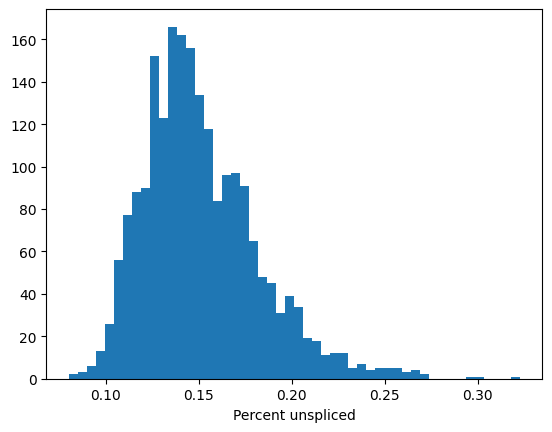

In [51]:
plt.hist(Usum/(Usum+Ssum), bins=50)
plt.xlabel("Percent unspliced")
plt.show()

In [52]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [53]:
data

# Perform some very basic gene filtering
sc.pp.filter_genes(data, min_cells=1)
data = data[:, data.layers["unspliced"].mean(0) > 0.1/2].copy()
data = data[:, data.layers["spliced"].mean(0) > 0.3/2].copy()
data

AnnData object with n_obs × n_vars = 2117 × 76
    obs: 'area', 'pass_basic_filter', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'annotation', 'batch', 'annotation2', 'S_score', 'G2M_score', 'phase', 'phase_prior'
    var: 'pass_basic_filter', 'n_cells'
    uns: '__type', 'annotation_colors', 'louvain', 'neighbors', 'pp', 'spatial', 'annotation2_colors', 'phase_colors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [54]:
data = data[data.layers["unspliced"].sum(1) > 2].copy()
data = data[data.layers["spliced"].sum(1) > 2].copy()
data

AnnData object with n_obs × n_vars = 1849 × 76
    obs: 'area', 'pass_basic_filter', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'annotation', 'batch', 'annotation2', 'S_score', 'G2M_score', 'phase', 'phase_prior'
    var: 'pass_basic_filter', 'n_cells'
    uns: '__type', 'annotation_colors', 'louvain', 'neighbors', 'pp', 'spatial', 'annotation2_colors', 'phase_colors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [55]:
Usum = data.layers["unspliced"].toarray().sum(1)
Ssum = data.layers["spliced"].toarray().sum(1)
min(Usum), min(Ssum)

(3, 3)

In [56]:
# Rough approximation of the cell cycle phase using categorical approaches 
#sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [57]:
data.obs["phase"].value_counts()

phase
G2M    1195
S       375
G1      279
Name: count, dtype: int64

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


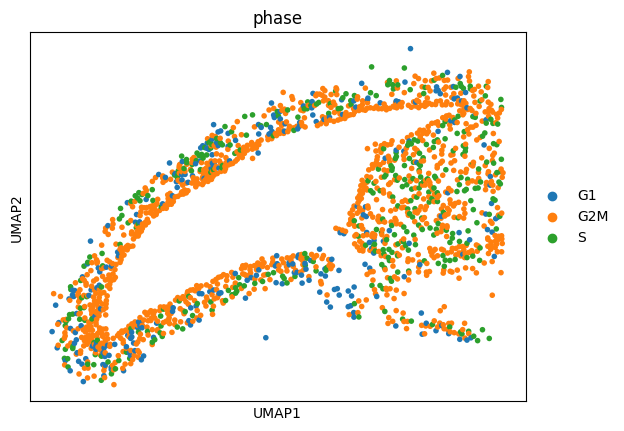

In [58]:
sc.pl.umap(data, color='phase')#, save="Stereoseq_radial_glia_spatial_coordinates.png")

In [59]:
# Get biologically-relevant gene set to use for velocity estimation (optional)
full_keep_genes = np.array(data.var.index)

## Initialize cycle and phase objects with priors

In [60]:
n_harm = 1
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)

In [61]:
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [62]:
data_to_fit

AnnData object with n_obs × n_vars = 1849 × 76
    obs: 'area', 'pass_basic_filter', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'annotation', 'batch', 'annotation2', 'S_score', 'G2M_score', 'phase', 'phase_prior'
    var: 'pass_basic_filter', 'n_cells'
    uns: '__type', 'annotation_colors', 'louvain', 'neighbors', 'pp', 'spatial', 'annotation2_colors', 'phase_colors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [63]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data_to_fit, ids="batch")

In [64]:
preprocessing.normalize_total(data_to_fit)

In [65]:
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data_to_fit, filter_type="intersection")

In [66]:
# Update the priors for gene harmonics
# to gene-specific means and stds
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

if(n_harm==2): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0, 0*nu0, 0*nu0))
if(n_harm==1): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
if(n_harm==0): S_frac_means=nu0[None, :]
cycle_prior.set_means(S_frac_means)

nu0std = np.std(np.log(S+1), axis=0)/2
if(n_harm==2): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std, 0.2*nu0std, 0.2*nu0std))
if(n_harm==1): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
if(n_harm==0): S_frac_stds=nu0[None, :]
cycle_prior.set_stds(S_frac_stds)

In [67]:
data_to_fit.layers["S_sz_log"] = data_to_fit.layers["S_sz"]

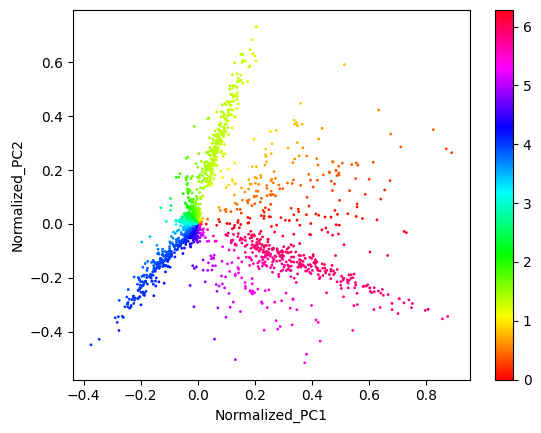

In [68]:
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, genes_to_use=utils.get_cycling_gene_set(size="Large", species="Human"),
                                               layer='S_sz_log', concentration=1, plot=True, small_count=1)

In [69]:
data_to_fit.obsm["X_pca"] = phase_prior.pcs

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


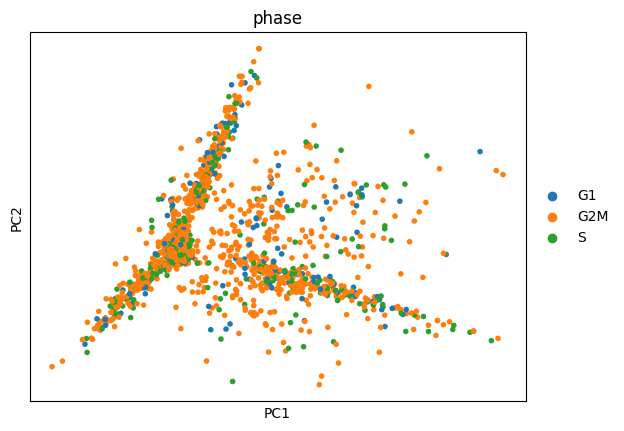

In [70]:
sc.pl.pca(data_to_fit, color=[ "phase"])

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

In [72]:
X_LDA = clf.fit_transform(data_to_fit.layers["S_sz"], data_to_fit.obs["phase"])

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


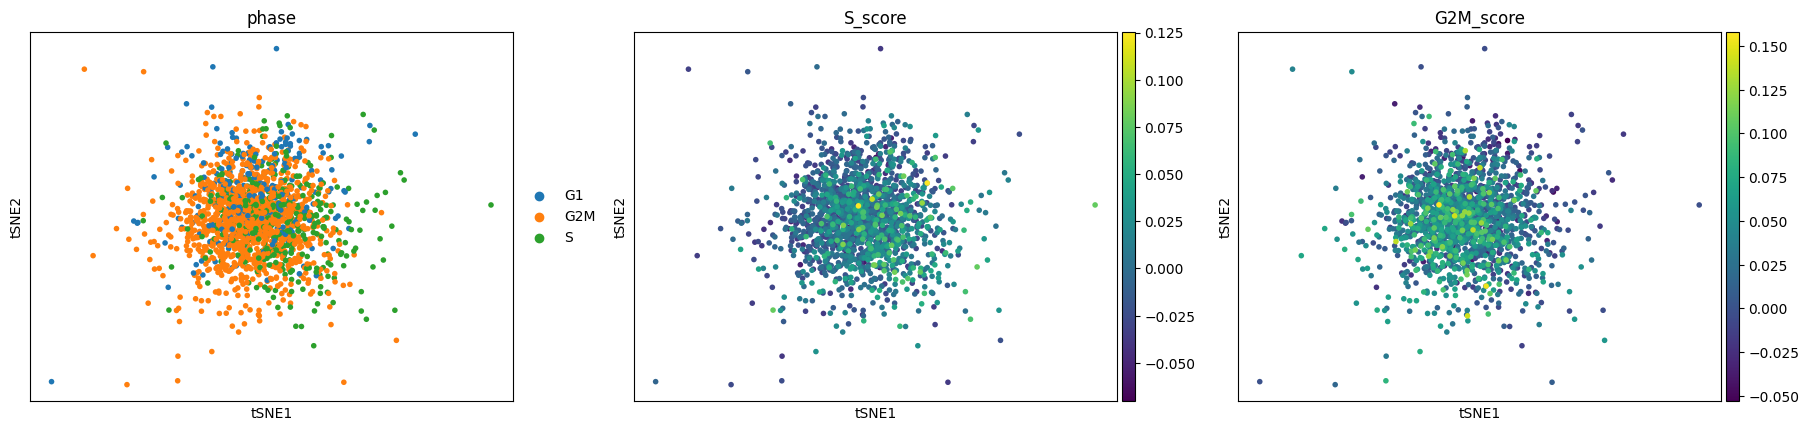

In [73]:
data_to_fit.obsm["X_tsne"] = X_LDA
sc.pl.tsne(data_to_fit, color=['phase', "S_score", "G2M_score"])

In [74]:
pcts = np.percentile(X_LDA, [0.5, 99.5, 50], 0)
X_LDA = (X_LDA - pcts[2, :]) / (pcts[1, :] - pcts[0, :])
angle = np.arctan2(X_LDA[:, 1], X_LDA[:, 0]) % (2 * np.pi)

/home/lederer/anaconda3/envs/dynamo-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


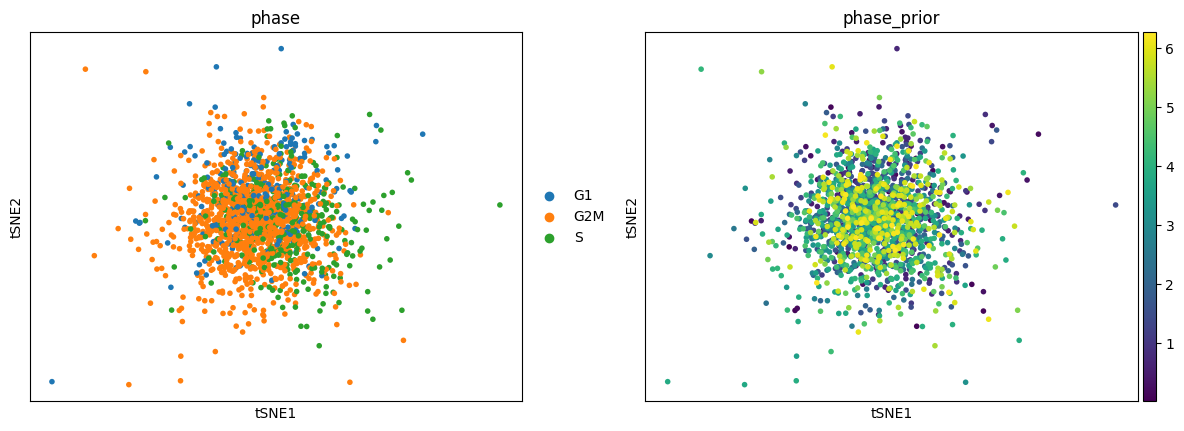

In [75]:
#data_to_fit.obs["phase_prior"] = angle
sc.pl.tsne(data_to_fit, color=['phase', "phase_prior"])

In [76]:
phase_prior = phases.Phases.from_array(utils.unpack_direction(torch.tensor(np.array(data_to_fit.obs["phase_prior"]))).T, 
                                       cell_names=np.array(data_to_fit.obs.index))

In [77]:
data_to_fit.obs["phase"] = data_to_fit_ref[data.obs.index].obs["phase"]

In [78]:
preprocessing.invert_direction(cycle_prior, phase_prior)

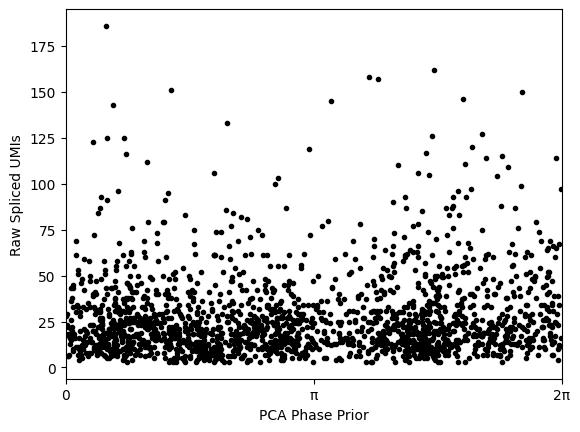

In [79]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

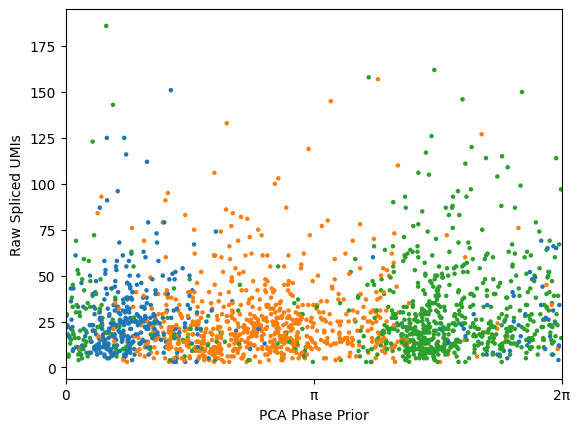

In [80]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
plt.scatter(phase_prior.phis, data_to_fit.obs.n_scounts, c=[name2color[i] for i in data_to_fit.obs["phase"]], s=5)
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

# Run the manifold-learning module

In [81]:
pyro.clear_param_store()

In [82]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data_to_fit, ids="batch")

In [83]:
Δν = torch.zeros(data_to_fit.n_vars).unsqueeze(-1).float().unsqueeze(-3).to(device)

In [84]:
condition_on_dict = {"Δν": Δν}

In [85]:
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, #pyro_ref
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          normalize=False, 
                                          behavior="intersection", 
                                          noisemodel="NegativeBinomial", 
                                          gene_selection_model="all",
                                          n_harmonics=n_harm, 
                                          device = device,
                                          condition_on=condition_on_dict)

In [86]:
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar,
                          condition_on=condition_on_dict, early_exit=False)
phase_fit.check_model()

 Trace Shapes:                             
  Param Sites:                             
 Sample Sites:                             
    cells dist             |               
         value        1849 |               
    genes dist             |               
         value          76 |               
  batches dist             |               
         value           1 |               
        ν dist     76    1 |    3          
         value     76    1 |    3          
       Δν dist   1 76    1 |               
         value   1 76    1 |               
      ϕxy dist        1849 |    2          
         value        1849 |    2          
        ϕ dist             | 1849          
         value             | 1849          
        ζ dist             | 1849 3        
         value             | 1849 3        
    ElogS dist             |    1 1 76 1849
         value             |    1 1 76 1849
shape_inv dist     76    1 |               
         value     76    1 |    

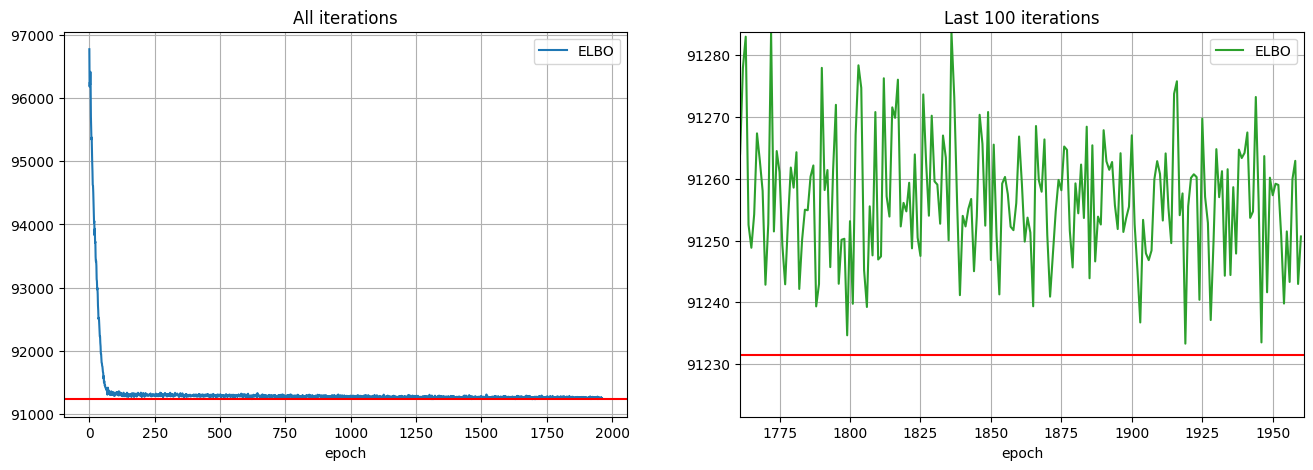

In [87]:
num_steps = 2000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

In [88]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [89]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze()
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze()

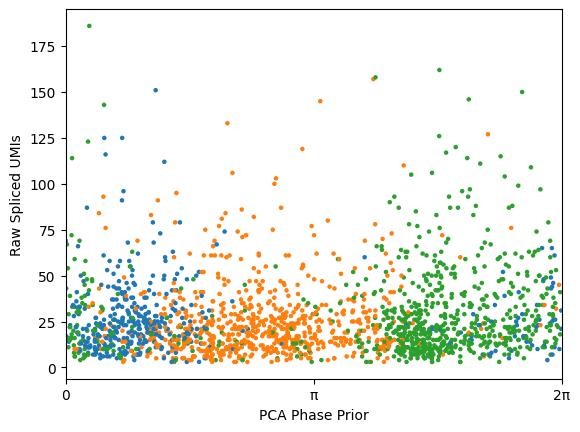

In [90]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
plt.scatter(phase_pyro.phis, data_to_fit.obs.n_scounts, c=[name2color[i] for i in data_to_fit.obs["phase"]], s=5)
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

In [91]:
data_to_fit.obs["phis"] = phase_fit.phase_pyro.phis.numpy()

# Run the velocity-learning module

In [92]:
pyro.clear_param_store()

In [93]:
# One only condition, so the design matrix is the same as for batches
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [94]:
n_velo_harmonics = 0
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["RG"], harmonics=n_velo_harmonics, 
                                                means=0.0, stds=3.0)

In [95]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [96]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix, 
                                                             batch_design_matrix, 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics, 
                                                             gene_selection_model="all",
                                                             normalize=False,
                                                             noisemodel="NegativeBinomial",
                                                             μγ=torch.tensor(0.0).detach().clone().float(),#.repeat([metapar.Ng, 1]),
                                                             σγ=torch.tensor(0.5).detach().clone().float(),#.repeat([metapar.Ng, 1]),
                                                             μβ=torch.tensor(2.0).detach().clone().float(),#.repeat([metapar.Ng, 1]),
                                                             σβ=torch.tensor(3.0).detach().clone().float(),#.repeat([metapar.Ng, 1]),
                                                             device=device,
                                                             model_type="normal",
                                                             rho_mean=torch.tensor(4.0).to(device),
                                                             rho_rank=torch.tensor(5).to(device),
                                                             condition_on=condition_on_dict)

In [97]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict, early_exit=False)
velocity_fit.check_model()

  Trace Shapes:                                  
   Param Sites:                                  
  Sample Sites:                                  
     cells dist               |                  
          value          1849 |                  
     genes dist               |                  
          value            76 |                  
 harmonics dist               |                  
          value             1 |                  
conditions dist               |                  
          value             1 |                  
   batches dist               |                  
          value             1 |                  
     logγg dist       76    1 |                  
          value       76    1 |                  
     logβg dist       76    1 |                  
          value       76    1 |                  
        γg dist       76    1 |   76    1        
          value               |   76    1        
         ν dist       76    1 |    3             


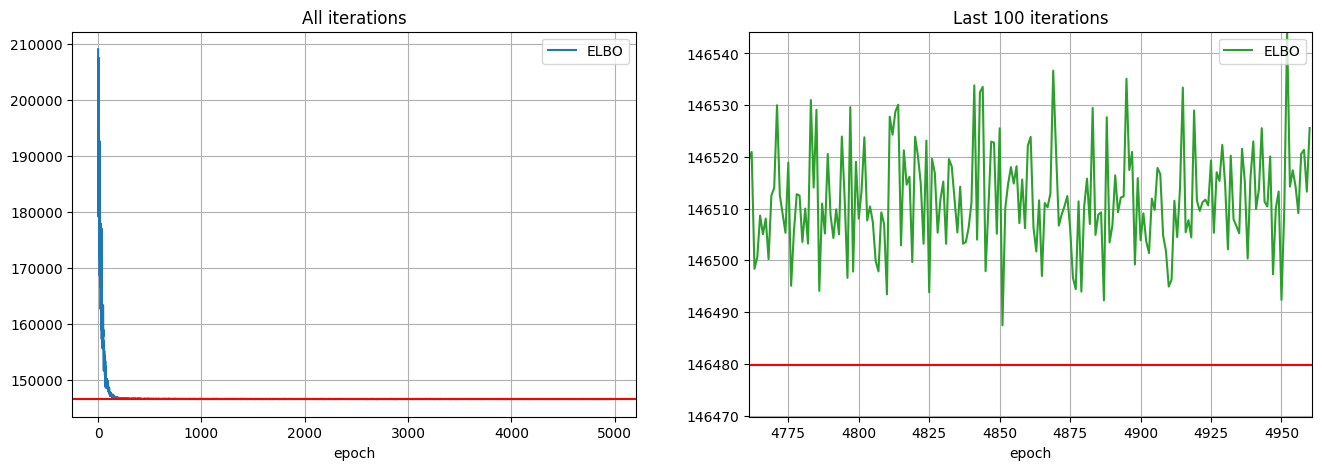

In [98]:
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [99]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

In [100]:
log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

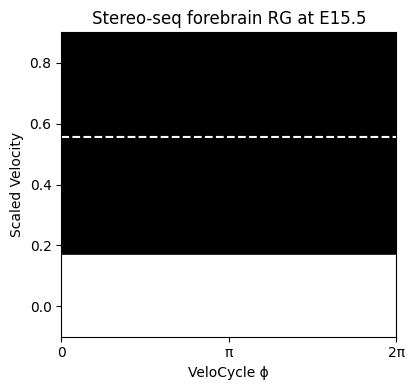

In [101]:
mean_gamma = np.exp(np.mean(log_gammas))
omega = velocity_fit.posterior["ω"].squeeze().numpy() / mean_gamma
phi = phase_pyro.phis

tmp5 = np.percentile(omega, 0, axis=0)
tmp95 = np.percentile(omega, 100, axis=0)

plt.figure(None, (4.25,4))
plt.fill_between(x=phi[np.argsort(phi)],
                 y1=tmp5[np.argsort(phi)], 
                 y2=tmp95[np.argsort(phi)], 
                 color="black", alpha=1)

plt.plot(phi[np.argsort(phi)], omega.mean(0)[np.argsort(phi)], 
      linestyle="dashed", c='white')
plt.ylabel("Scaled Velocity")#, size=15, fontweight='bold')
plt.xlabel("VeloCycle ϕ")#, size=15, fontweight='bold')
plt.title("Stereo-seq forebrain RG at E15.5")
plt.xlim(0, 2*np.pi)
plt.ylim(-0.1, 0.9)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])#, size=12)
plt.tight_layout()
plt.show()